<a href="https://colab.research.google.com/github/ldsbalu/Balu-Portfolio/blob/main/lab8_self_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/porterjenkins/byu-cs474/blob/master/lab8_self_attention.ipynb)

# The Transformer and Attention

In this lab, you will create a transformer. We will be performing the same task as the RNN lab: generating text using a decoder-only scheme. Instead of a character-by-character approach, we will do token-by-token (which is similar to word-by-word) generation.

### Based on "Attention is All You Need" (https://arxiv.org/abs/1706.03762)
Note: these use the encoder-decoder approach. This is only necessary if we have a separate input and output sequence, like in a translation task. Here, our input and output sequence are the same, therefore we will use a decoder-only approach.
### Also useful:
http://jalammar.github.io/illustrated-transformer/

## Setup


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math, copy, time, collections

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on {}".format(device))

Running on cuda


---

# Examining the Dataset

As always, we will begin by examining our data.

Since we are performing the same task as the previous lab, we can use the same dataset.

In [3]:
!pip install unidecode
import unidecode

!wget -q --show-progress -O ./text_files.tar.gz 'https://piazza.com/redirect/s3?bucket=uploads&prefix=attach%2Fjlifkda6h0x5bk%2Fhzosotq4zil49m%2Fjn13x09arfeb%2Ftext_files.tar.gz'
!tar -xzf text_files.tar.gz
file = unidecode.unidecode(open('./text_files/lotr.txt').read())

print(f"'file' is of type {type(file)} and contains {len(file)} characters\n")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.7 MB/s eta 0:00:00
./text_files.tar.gz 100%[===================>]   1.46M  --.-KB/s    in 0.08s   
'file' is of type <class 'str'> and contains 2579888 characters



## Tokenization

Unlike last lab, we don't want to process our input character-by-character. Characters generally don't contain much semantic meaning, while words do. To use words as the base unit for our model, we need to separate the text into a sequence of words. We'll use the `spaCy` library to tokenize our text so we don't have to.

**NOTE:** If you were using a non-English language corpus, this lab should work just fine, but you will need to find a language-appropriate spaCy model.

In [4]:
!python -m spacy download en_core_web_sm

import spacy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 76.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [5]:
spacy_model = spacy.load('en_core_web_sm')
def tokenize(line):
  return [tok.text for tok in spacy_model.tokenizer(line)]

Now lets tokenize the whole file and print out random sections of tokens.

In [6]:
all_tokens = tokenize(file)
print("The file is {} tokens long".format(len(all_tokens)))

The file is 618270 tokens long


In [7]:
seq_len_words = 30
for _ in range(4):
  i = np.random.randint(len(all_tokens) - seq_len_words)
  seq = all_tokens[i:i+seq_len_words]
  print(seq)
  print(' '.join(seq))
  print()

['is', 'a', 'chapter', 'of', 'ancient', '\n\n\n\n\n', 'history', 'which', 'it', 'might', 'be', 'good', 'to', 'recall', ';', 'for', 'there', 'was', 'sorrow', 'then', 'too', ',', 'and', '\n', 'gathering', 'dark', ',', 'but', 'great', 'valour']
is a chapter of ancient 




 history which it might be good to recall ; for there was sorrow then too , and 
 gathering dark , but great valour

['gimlets', '\n', 'in', 'the', 'dark', '.', 'But', 'these', 'Whiteskins', 'have', 'better', 'night', '-', 'eyes', 'than', 'most', 'Men', ',', 'from', '\n', 'all', 'I', "'ve", 'heard', ';', 'and', 'do', "n't", 'forget', 'their']
gimlets 
 in the dark . But these Whiteskins have better night - eyes than most Men , from 
 all I 've heard ; and do n't forget their

['know', ',', 'because', 'they', "'d", 'have', 'been', 'forgotten', '.', 'We', 'hear', 'about', '\n', 'those', 'as', 'just', 'went', 'on', '--', 'and', 'not', 'all', 'to', 'a', 'good', 'end', ',', 'mind', 'you', ';']
know , because they 'd have bee

We are using a simple tokenizer, which mostly just splits at word boundaries, but also splits off punctuation and some compound words ("don't" is tokenized as "do", "n't"). More complex tokenizers may split parts of words as well (separating roots, prefixes, and suffixes).

Like in the RNN lab, we can't use these tokens as input to our model yet: we need to turn them into numerical data.
Eventually we'll use word embeddings (`nn.Embedding`), but for now, we can turn them into indices for our embedding layer.
We can build a vocabulary using the tokens in our corpus.
Any word that appears less than `MIN_FREQ` times will be interpreted as an `<UNK>` (unknown) token, as we shouldn't expect our model to learn such an infrequent token.
Even if we set `MIN_FREQ=1`, our model can encounter new tokens after training.

We have provided a custom vocabulary class. This is based on the functionality of torchtext.vocab, but torchtext is depreciated and cannot be imported with newer versions of PyTorch.

In [8]:
class Vocab:
    def __init__(self, tokens, special_tokens=['<UNK>'], min_freq=0, default_token='<UNK>'):
        counter = collections.Counter()
        counter.update(tokens)
        self.vocab_list = [token for token, count in counter.items() if count >= min_freq]
        if default_token not in special_tokens:
            special_tokens.append(default_token)
        self.vocab_list += special_tokens
        # Reverse vocab list w/ dictionary
        self.vocab_dict = dict([(token, i) for i, token in enumerate(self.vocab_list)])
        self.default_idx = self.vocab_dict[default_token]

    def idx_to_token(self, i):
        return self.vocab_list[i]

    def idx_tensor_to_tokens(self, indices):
        return [self.vocab_list[i.item()] for i in indices]

    def token_to_idx(self, token):
        try:
            return self.vocab_dict[token]
        except KeyError:
            return self.default_idx

    def tokens_to_idx_list(self, text):
        return [self.token_to_idx(token) for token in text]

    def __len__(self):
        return len(self.vocab_list)

In [9]:
UNK_TOKEN = '<UNK>'
vocab = Vocab(all_tokens, [UNK_TOKEN], min_freq=2, default_token=UNK_TOKEN)
print("Vocabulary contains {} unique tokens.".format(len(vocab)))

Vocabulary contains 9523 unique tokens.


This vocab object gives us a dictionary that we can use to transform tokens between string and integer representations.

In [10]:
print(f"Token Index {5} => {vocab.idx_to_token(5)}")
print(f"Token RINGS => {vocab.token_to_idx('RINGS')}")

Token Index 5 => RINGS
Token RINGS => 5


Note that the vocabulary is case-sensitive. For the Lord of the Rings corpus, "Gandalf" is in the vocabulary, but "gandalf" is not and defaults to the "\<UNK\>" token.

In [11]:
print("Gandalf => {} ({})".format(vocab.idx_to_token(vocab.token_to_idx('Gandalf')), vocab.token_to_idx("Gandalf")))
print("galdalf => {} ({})".format(vocab.idx_to_token(vocab.token_to_idx('gandalf')), vocab.token_to_idx("gandalf")))

Gandalf => Gandalf (315)
galdalf => <UNK> (9522)


Now we have all the tools to implement the `LOTRDataset`.
Use the sequence of Lord of the Rings tokens (`lotr_token_sequence`) and the `vocab` object to return sequences of token indices.
`.__getitem__(self, i)` should output an input sequence of token ids `token_ids[i : i+chuck_length]` and a target sequence of token ids `token_ids[i+1 : i+chuck_length+1]`.

In [12]:
class LOTRDataset(Dataset):
    def __init__(self, lotr_token_sequence, vocab, chunk_length):
        self.token_ids = torch.tensor(vocab.tokens_to_idx_list(lotr_token_sequence))
        self.chunk_length = chunk_length


    def __getitem__(self, i):
        if i + self.chunk_length + 1 >= len(self.token_ids):
            raise IndexError("index out of range")
        input_sequence = self.token_ids[i : i+self.chunk_length]
        target_sequence = self.token_ids[i+1 : i+self.chunk_length+1]
        return input_sequence, target_sequence

    def __len__(self):
        return len(self.token_ids) - self.chunk_length

CHUNK_LENGTH = 128
BATCH_SIZE = 64

dataset = LOTRDataset(all_tokens, vocab, CHUNK_LENGTH)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [13]:
input_idxs, target_idxs = next(iter(dataloader))
print('Input Token Ids:', input_idxs[0, :32])
print('Target Token Ids:', target_idxs[0, :32])
print('\nInput Tokens:', vocab.idx_tensor_to_tokens(input_idxs[0, :32]))
print('\nTarget Tokens:', vocab.idx_tensor_to_tokens(target_idxs[0, :32]))

Input Token Ids: tensor([ 522, 1172,    0,  977,  185,  119, 3643,  189, 1063, 1225,   24, 1071,
         285, 1528,  185,  522, 4242,   24,    0, 1157,  185,  119,  228, 1813,
         463,  288,  855, 1217,  544,  189, 1052, 1028])
Target Token Ids: tensor([1172,    0,  977,  185,  119, 3643,  189, 1063, 1225,   24, 1071,  285,
        1528,  185,  522, 4242,   24,    0, 1157,  185,  119,  228, 1813,  463,
         288,  855, 1217,  544,  189, 1052, 1028,  185])

Input Tokens: ['he', 'turned', '\n', 'suddenly', ',', 'and', 'choosing', 'a', 'place', 'where', 'the', 'banks', 'were', 'lower', ',', 'he', 'waded', 'the', '\n', 'river', ',', 'and', 'then', 'led', 'them', 'away', 'due', 'south', 'into', 'a', 'flat', 'land']

Target Tokens: ['turned', '\n', 'suddenly', ',', 'and', 'choosing', 'a', 'place', 'where', 'the', 'banks', 'were', 'lower', ',', 'he', 'waded', 'the', '\n', 'river', ',', 'and', 'then', 'led', 'them', 'away', 'due', 'south', 'into', 'a', 'flat', 'land', ',']


If you implemented the dataset correctly, your target tokens/indices should be one token/index ahead of the input tokens/indices.

# Model

For the transformer model, we'll use a decoder-only scheme. We do not need an encoder because the output sequence and input sequence are the same.
Our model will taken in a sequence of token ids (shape `(B, S)`) and map them to a sequence of next token predictions (shape `(B, S, C)`) where the last dimension `C` is an unnormalized distribution over the class of tokens.

## Input Embeddings

The transformer model takes in a sequence of token ids (shape `(B, S)`) and maps them into feature vectors (shape `(B, S, Z)`). This is a two part process involving scaled embeddings and positional encodings.

### Scaled Embedding

The typical way to map ids to feature vectors is with an `nn.Embedding` layer, but because the vocab size is so large we should scale the embeddings so they are different enough from each other.
Implement `ScaledEmbedding` by instantiating an `nn.Embedding` layer and in the `.forward()` scaling the embedding layer's output by the by the square root of its embedding dimension.

In [14]:
class ScaledEmbedding(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.scale = math.sqrt(embedding_dim)

    def forward(self, x):
        return self.embedding(x) * self.scale

### Positional Encoding                                                                                                                             

The second part of creating our input embeddings is to use positional encodings.
Since our model contains no recurrence and no convolution, in order for the model to know the order of the sequence, we must inject some information about the relative or absolute position of the tokens in the sequence.
To this end, we add "positional encoding" information to the input embeddings.
The positional encodings have the same dimension $d_{\text{model}}$ as the embeddings, so that the two can be summed.
There are many choices of positional encodings, learned and fixed [(cite)](https://arxiv.org/pdf/1705.03122.pdf).

We will use sine and cosine functions of different frequencies (this is from the "Attention Is All You Need" paper):                                                                                                                                                                                                                                                                                                                                                                                                                
$$PE_{(pos,2i)} = sin(pos / 10000^{2i/d_{\text{model}}})$$

$$PE_{(pos,2i+1)} = cos(pos / 10000^{2i/d_{\text{model}}})$$                                                                                                                                                                                                                                                        
where $pos$ is the position and $i$ is the dimension.

**Note:** *Everything has been implemented for you, just read this section to understand the utility behind positional encodings.*

In [15]:
class PositionalEncoding(nn.Module):
    """Implements the PE function.
       The forward adds the positional encoding to the input encoding
    """
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = 1 / (10000 ** (torch.arange(0., d_model, 2) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)],
                         requires_grad=False)
        return self.dropout(x)

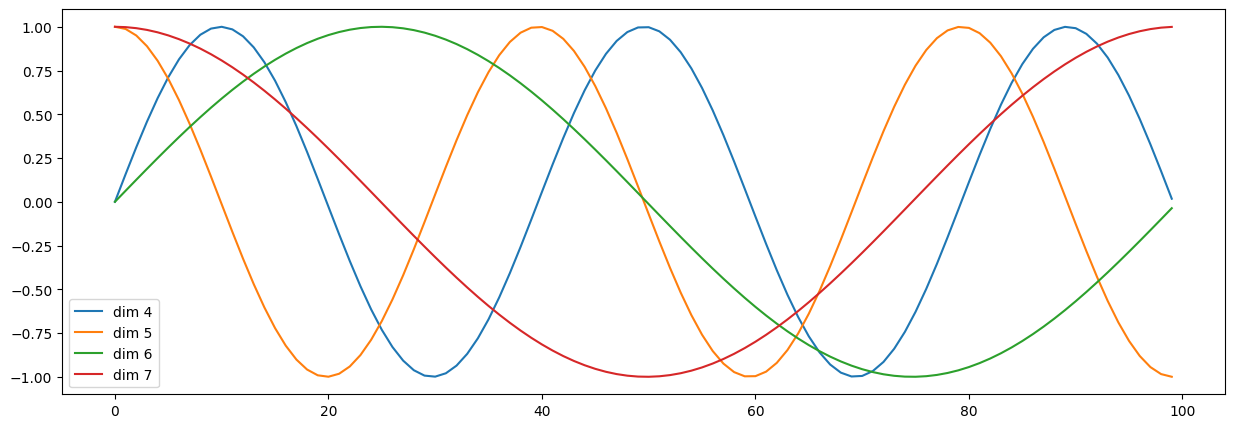

In [16]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(torch.zeros(1, 100, 20))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])
plt.show()

## Attention

We now implement the core mechanism behind the transformer: Attention.

Attention operates on queries and key-value pairs. The query tensor can be thought of as an input that is transformed into a linear combination of the value tensors. The weights of this linear combination are determined by how similar the query is to the corresponding key tensor. This operation is performed by "scaled dot product attention" or simply `attention()`.

Our transformer model will use different representations of our input embeddings to form query, key, and value tensors. Attention will help the model determine what tokens to focus on and how to represent the tokens.

Implement `attention` below.

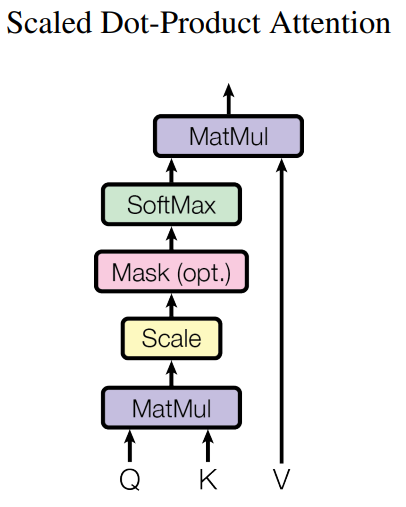

In [23]:
def attention(query, key, value, mask):
    """Compute 'Scaled Dot Product Attention'
       Inputs are embedded tensors.
       Since we are doing self-attention, query, key, and value all come from
       the sequence we're predicting on. They will be shaped:
       (batch, sequence_length (num_tokens), embedding_dim)
       Be sure you are performing operations over the correct dimensions!
    """

    # scores = QK^T/scale
    scores = torch.matmul(query, torch.transpose(key, -2, -1))

    # We will discuss masking below. For now, if the mask is not None, then add the mask to the scores.
    d_k = query.size(-1)  # Dimension of the key vectors
    scores = scores / torch.sqrt(torch.tensor(d_k, dtype=torch.float32))

    if mask is not None:
        scores = scores.masked_fill(mask == 0, float('-inf'))


    # output = softmax(scores)(V)
    attention_weights = F.softmax(scores, dim=-1)
    output = torch.matmul(attention_weights, value)

    return output

PyTorch has an implementation of [scaled dot product attention](https://pytorch.org/docs/stable/generated/torch.nn.functional.scaled_dot_product_attention.html). Use `F.scaled_dot_product_attention` with `mask=None` to verify that your attention module is correctly implemented.

In [24]:
q = torch.randn(12, 200, 64)
k = torch.randn(12, 200, 64)
v = torch.randn(12, 200, 64)
assert torch.allclose(attention(q, k, v, None), F.scaled_dot_product_attention(q, k, v, None), rtol=1e-5, atol=1e-6)

## Masking

Forget the batch dimension at the moment and assume that our input tensors `(Q, K, V)` for the `attention` function are of shape `(S, Z)`, where `S` is the sequence length and `Z` is the feature size. The matrix multiplication with softmax on `Q` and `K`, i.e. `softmax(QK^T)`, gives us an `(S, S)` matrix where row $i$ is a probability distribution over which tokens in the sequence are important for the learning task. If our task is to predict the next token (e.g. word), then the transformer could easily cheat by having token $i$ look at token $i+1$.

<!-- We can use masking to avoid having to do recurrent inputs when training. Instead, we can predict the next word in the sequence at each step in the sequence. But there's an issue: if  -->

For example, if we get the sequence `I am very happy today .` as input, the transformer can just look at the next token and predict: `am very happy today . ---`. If our model learns this, it won't work in practice because we don't have the whole sequence when generating text.

The only time our model mixes information between tokens is in the attention layers. In order to perform attention so that a token embedding can only look itself and the tokens to the left of it, we create a mask that blocks out future information.

`       I____ am___ very_ happy today .____`

`I____: TRUE_ FALSE FALSE FALSE FALSE FALSE`

`am___: TRUE_ TRUE_ FALSE FALSE FALSE FALSE`

`very_: TRUE_ TRUE_ TRUE_ FALSE FALSE FALSE`

`happy: TRUE_ TRUE_ TRUE_ TRUE_ FALSE FALSE`

`today: TRUE_ TRUE_ TRUE_ TRUE_ TRUE_ FALSE`

`.____: TRUE_ TRUE_ TRUE_ TRUE_ TRUE_ TRUE_`


This means every token right of the current token should have a probability of zero.
This is accomplished by setting their logits to $- \infty$ (or really small) so that the softmax results in them being zero.
Implement the `create_mask` function to output an `(S, S)` matrix with a value of 0 on the diagonal and below (i.e. everywhere that is True in the matrix above) and a value of `-torch.inf` above the diagonal (i.e. everwhere that is False in the matrix above).

**Tip:** Use `torch.full()` to create an `(S, S)` matrix full of `-torch.inf` values and then use `torch.triu()` to set the appropriate values to zero.

In [25]:
def create_mask(sequence_length):
     # Create a matrix full of -inf values
    mask = torch.full((sequence_length, sequence_length), -torch.inf)

    # Set values on and below the diagonal to 0
    mask = torch.triu(mask, diagonal=1)

    return mask


You should print out your mask to make sure it is correct, but the function below is a visual test of `create_mask` working with softmax.
Before masking we have probabilities across the entire sequence, but after masking you should have probabilities:
$$\begin{bmatrix} 1 & 0 & 0 & 0 \\ .5 & .5 & 0 & 0 \\ .33 & .33 & .33 & 0 \\ .25 & .25 & .25 & .25  \end{bmatrix}$$

In [27]:
def viz_create_mask():
    sequence_length = 4
    mask = create_mask(sequence_length)
    logits = torch.ones((sequence_length, sequence_length))

    print("Before masking:")
    print(torch.softmax(logits, dim=-1))

    print("\nAfter masking:")
    print(torch.softmax(logits + mask, dim=-1))

viz_create_mask()

Before masking:
tensor([[0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500]])

After masking:
tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500]])


The masking makes it so we don't have to do recurrent inputs when we train: we can predict on all the target tokens on one pass instead of doing one forward pass for each token.

### Multi-Headed Attention Module

`attention()` by itself has no learnable parameters, in order to learn how to use attention we will create linear layers that turn the input sequence(s) into queries, keys, and values. The transformer learns how to use attention by learning the parameters of these linear layers.

Performing one round of attention is like having a convolution layer with a single channel: it can only look for one type of feature. Just like with using multiple learned filters for convolutions and using multiple neurons for linear layers, we will perform multiple rounds of attention on the same input (with the only difference being the parameters in the linear layers). We refer to this as multi-headed attention: each head performs attention on one set of queries, keys, and values. At the end of the module, we combine the information from each head.

Create a parameterized multi-headed attention module as described in described in [Attention is All You Need (Vaswani et al.)](https://arxiv.org/pdf/1706.03762.pdf). Note that each head will need separate parameters, as well as each query, key, and value. So you should have $3h$ sets of parameters, plus the final linear layer.

To ensure the computation costs don't increase h-times, you can give each head an embedding dimension size of `d_model // h`. When you concatenate them together at the end, you'll still end up with an embedding of size `d_model`.

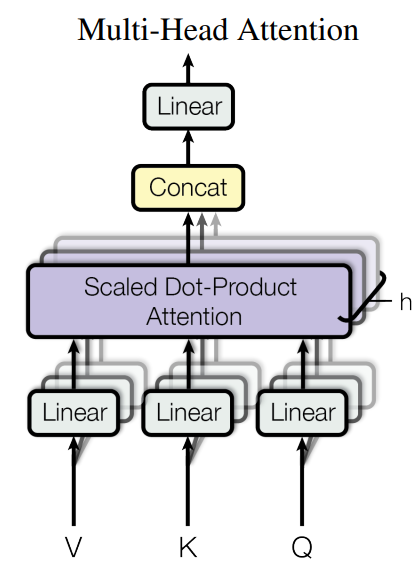

In [28]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model):
        super().__init__()
        # Implement Multi-head attention mechanism

        # Make h attention heads (linear layers) for q, k, and v
        # If you use lists, make sure to wrap them in `ModuleList` objects!
        assert d_model % h == 0, "d_model must be divisible by the number of heads"

        self.h = h  # Number of attention heads
        self.d_k = d_model // h  # Dimensionality per head

        # Linear layers for query, key, and value transformations
        self.query = nn.Linear(d_model, d_model)
        self.key = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)

        # Final linear layer to combine head outputs
        self.output = nn.Linear(d_model, d_model)

    def forward(self, q_seq_embedding, kv_seq_embedding, mask):
        # While q_seq_embedding == kv_seq_embedding in our lab, because we are performing self-attention,
        # we have separated them as two input parameters because it is not the only form of attention.

        # For each attention head
            # Produce a query from q_seq_embedding, and a key-value pair of tensors from kv_seq_embedding
            # Compute scaled dot-product attention on the output using your function

        # Combine head outputs

        batch_size = q_seq_embedding.size(0)

        # Linear transformations for query, key, and value
        query = self.query(q_seq_embedding)  # Shape: (B, S, d_model)
        key = self.key(kv_seq_embedding)    # Shape: (B, S, d_model)
        value = self.value(kv_seq_embedding)  # Shape: (B, S, d_model)

        # Split into multiple heads
        query = query.view(batch_size, -1, self.h, self.d_k).transpose(1, 2)
        key = key.view(batch_size, -1, self.h, self.d_k).transpose(1, 2)
        value = value.view(batch_size, -1, self.h, self.d_k).transpose(1, 2)

        # Scaled dot-product attention per head
        scores = torch.matmul(query, key.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.d_k).float())

        if mask is not None:
            scores = scores.masked_fill(mask.unsqueeze(1) == 0, float('-inf'))

        attention_weights = F.softmax(scores, dim=-1)

        head_outputs = torch.matmul(attention_weights, value)


        combined_heads = head_outputs.transpose(1, 2).contiguous().view(batch_size, -1, self.h * self.d_k)

        return self.output(combined_heads)


## Decoder

The decoder model is responsible for predicting the next character of the target or output sequence. For the text generation task, there is no input sequence or context that needs to be encoded (refer to the "Attention Is All You Need" diagram), so we have provided a diagram of the decoder-only architecture below.

The core module in the decoder are $N$ identical stacked layers, which you will implement as `DecoderLayer`.
The input `x` to a `DecoderLayer` is fed through a multi-headed attention layer.
Note that `x` is the source of the keys, queries, and values.
The output of the attention module is then added to `x` and we perform layer normalization (via `nn.LayerNorm`).
This output is then fed to a feed forward network (refer to section 3.3 in the [Attention Is All You Need](https://arxiv.org/pdf/1706.03762)).
The output of the feed forward network is then added to its input and you perform another layer normalization (so instantiate two layer norm layers).

Before you perform an "add and norm" operation, you should apply a dropout (`nn.Dropout`) to the output (refer to section 5.4).  

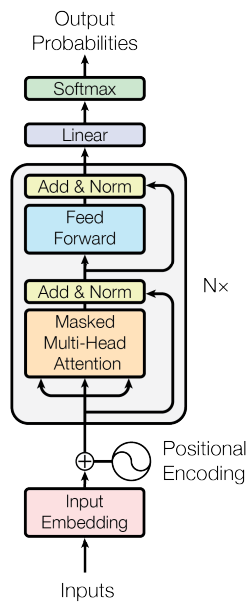

In [29]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, d_ff, h, dropout=0.1):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=h, dropout=dropout, batch_first=True)

        # Feed-forward network
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )

        # Layer normalization
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

        # Dropout layers
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)


    def forward(self, x, mask):
        attn_output, _ = self.self_attn(x, x, x, attn_mask=mask)
        x = self.norm1(x + self.dropout1(attn_output))

        # Feed-forward network with residual connection and layer normalization
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout2(ff_output))

        return x


Implement the `TransformerDecoder` (the entire model in the figure above). It should contain a `ScaledEmbedding`, a `PositionalEncoding`, `N` `DecoderLayer` modules, and a `nn.Linear`.
Embed the input token ids with the `ScaledEmbedding` layer followed by the `PositionalEncoding` layer.
Each `DecoderLayer` is stacked, feeding its output as the next layer's input.
The output of our stacked `DecoderLayer`s should be converted into predictions (logits) of the next tokens through a `nn.Linear` layer.  
These predictions can then be compared to the true sequence with cross entropy loss (so do not apply softmax because the cross-entropy loss will do it), like any classification problem.

**Note:** *We performed Xavier initialization on the network parameters because it improved learning speed and performance.*

In [30]:
class TransformerDecoder(nn.Module):
    "N layer decoder-only transformer."

    def __init__(self, vocab_size, N=4, d_model=256, d_ff=512, h=4, dropout=.1):
        """
        vocab_size - number of tokens in vocabulary
        N - number of DecoderLayer modules
        d_model - embedding dimension
        d_ff - feed-forward hidden dimension
        h - number of attention heads
        dropout - dropout probability: used in PositionalEncoding, PositionalFeedForward, and AddAndNorm
        """
        super().__init__()
        # TODO: Create you layers here
        self.embedding = ScaledEmbedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, dropout)

        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, d_ff, h, dropout) for _ in range(N)])

        self.output_layer = nn.Linear(d_model, vocab_size)

        # Initialize parameters w/ xavier for better performance
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, x, mask):
        # Note that softmax is performed in CrossEntropyLoss, so don't use softmax at the end of the network.
        embedded = self.embedding(x)

        # Add positional encoding
        encoded = self.positional_encoding(embedded)

        # Pass through decoder layers
        for layer in self.decoder_layers:
            encoded = layer(encoded, mask)

        # Convert output to logits
        logits = self.output_layer(encoded)

        return logits

## Training and Inference

Remember the transformer's input is a LongTensor with shape `(B, S)`. and its output is a FloatTensor with shape `(B, S, C)`, where `C` is the number of classes, representing the sequence of next predicted tokens.
To generate text from our transformer given a priming token id, you input the sequence of one into the transformer and sample the last token prediction in the sequence, which is concatenated with the priming token id and fed back into our transformer and we repeat the process.

For example, our starting input of shape `(B, S=1)` (assuming we are using a single priming token) will give us an output of shape `(B, S=1, C)`.
We sample along the `C`-dimension to get our next token id and concatenate it with our priming token id sequence.
This means our next starting input is of shape `(B, S=2)` and the output will be `(B, S=2, C)`.
We only need to sample the last token prediction, i.e. `output[:, -1]`, because we have already sampled `output[:, 0]` in the previous step.

Implement the `generate()` function below to generate a sequence of tokens from a transformer model.

In [31]:
@torch.no_grad()
def generate(x, model, pred_length, temperature=.8):
    """
    Generate `pred_length` characters, given the starting sequence x.
    The model's output can be turned into a character prediction using
    softmax (divide the logits by temperature first), and then sampled
    from the multinomial distribution.
    Return the tensor of sampled integers.

    Make sure to provide the correct-shaped mask each iteration.
    """
    model.eval()  # Ensure the model is in evaluation mode
    for _ in range(pred_length):
        # Create a causal mask for the current sequence length
        seq_len = x.size(1)
        mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool().to(x.device)

        # Get logits from the model
        logits = model(x, mask)  # Shape: (B, S, vocab_size)

        # Extract the logits for the last token in the sequence
        last_logits = logits[:, -1, :]  # Shape: (B, vocab_size)

        # Apply temperature scaling and softmax to get probabilities
        probs = F.softmax(last_logits / temperature, dim=-1)  # Shape: (B, vocab_size)

        # Sample the next token from the multinomial distribution
        next_token = torch.multinomial(probs, num_samples=1)  # Shape: (B, 1)

        # Append the sampled token to the sequence
        x = torch.cat([x, next_token], dim=1)  # Shape: (B, S + 1)

    return x


Just like in the RNN lab, we want to print out our text generation evaluation throughout training, so we can better understand how the model is working.
Just like before, we provide a starting input and have the model predict the next character until we have generated enough text.
Note that this evaluation function will be very similar to the one using the RNN. Unlike the RNN, the transformer has no memory, so it must take in the entire sequence each time.

In [32]:
eval_start_tokens = ["The", "Where", "fight", "Gandalf"]
EVAL_START_TOKEN_IDS = torch.tensor([[vocab.token_to_idx(start_token)] for start_token in eval_start_tokens]).long()
def evaluate(model):
    """Runs generate function and formats and prints predictions.
    """
    model.eval()
    inference_batch = generate(EVAL_START_TOKEN_IDS.to(device), model, CHUNK_LENGTH)
    for inference_tokens in inference_batch:
        pred_tokens = vocab.idx_tensor_to_tokens(inference_tokens)
        print(' '.join(pred_tokens))
        print('='*200)
    print()
    model.train()

# Test that evaluate and generate work. Use an untrained model.
evaluate(TransformerDecoder(len(vocab)).to(device))
# Note that the output looks better than the untrained RNN.
# This is because the model can only output valid tokens.

The guiding muttered postponed returned Found unexpectedly help immovable shards log fitfully shapeless slaying Near curiosity strokes own thieving needlessly forging leaden bites ripples escape troops robed hewed pass nest note Radagast ambush -trail families removal Mortal succour bowls hut revenge delay eluded beforehand mound drew approach curtains nets arched custom brutes Others Angmar bowshot Eight crashing Hallo Messenger waves rill storage broadening loud smoked clash nothing fog increases led realm slowing skulls climb pardon axes Slay 22nd trying hung immeasurably loomed Edrendil treating deserves runes troubles suspense clip Hrum Beren records sweeping unnecessarily seeing fortunately appetite ours unlock Egladil Flight flared unimportant language unnecessarily Darkness hardly times gripped invaded Messenger strand bullying loomed string worry whiteness sunlight shortened innkeeper troubles lives ways pools fumbling cellar faint Revenge slept
Where suited concourse alarmed 

Now implement the `train` function to optimize your transformer model for `n_optimization_steps` and return the losses over time.
At every `eval_interval` print the current training loss and use `evaluate` to generate some text.

**Note:** *Remember that CrossEntropyLoss expects `y_hat.shape == (B*S, C)` and `y_truth.shape == (B*S,)` or `y_hat.shape == (B, C, S)` and `y_truth.shape == (B, S)`.*

In [40]:
def train(model, optimizer, dataloader, n_optimization_steps, eval_interval):
    # Label smoothing adds a bit of uncertainty to the model, improving text generation.
    loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)

    losses = []
    mask = create_mask(CHUNK_LENGTH).to(device)

    step = 0
    while step < n_optimization_steps:
        for input_sequence, target_sequence in dataloader:
            # Move input and target sequences to the correct device
            input_sequence = input_sequence.to(device)
            target_sequence = target_sequence.to(device)

            # Forward pass: compute logits
            logits = model(input_sequence, mask)


            logits_flat = logits.view(-1, logits.size(-1))
            target_flat = target_sequence.view(-1)


            loss = loss_fn(logits_flat, target_flat)


            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


            losses.append(loss.item())

            # Print and evaluate at intervals
            if step % eval_interval == 0:
                print(f"Step {step}/{n_optimization_steps}, Loss: {loss.item():.4f}")
                evaluate(model)  # Generate text to evaluate the model's progress

            step += 1
            if step >= n_optimization_steps:
                break




    return losses

Train your model. You want your final losses to be below 3.5.

In [41]:
model = TransformerDecoder(len(vocab), N=2, d_model=256, d_ff=512, h=8).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

losses = train(model, optimizer, dataloader, n_optimization_steps=5000, eval_interval=1000)

Step 0/5000, Loss: 9.1974
The wearier slinking Yea advice adopt plumes Might faintest Thunder thirst dym Ringwraith liking colony simbelmynl Bard mountain Several dangerously diminished squint uncle tracker loyalty robed advancing fairer cried standard shrubs granted bumped rogue clinging bothered ill shouting slugs points bears beast sprout sons cakes beech to grey upon cooked utter aimed -unless Stonewain tapping tame leaned greyness yawning Fountain crash less openings helmed bewilderment unclasped loping cracker Each Gladden stouthearted silivren vermin Anyway innkeeper unhappy dangling foamed Bridge bogs excited dry break forge increasing hardest fearing defy talk puckered More out- wrath overrun clutched Appledore friendliness War threats jokes tugging During bade Annyn roaming expected cared truly Land capped fade upland slash kings ravines rustic pushed eighth absence Orders unintelligible wire blown simply bubbled rearguard My danced private
Where hewed him delighted smaller s

## Plot losses

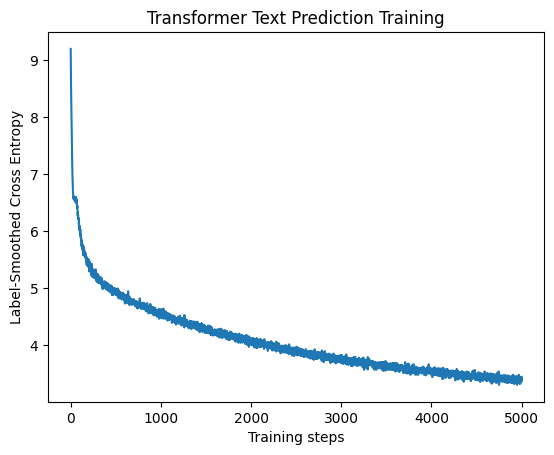

In [42]:
plt.plot(losses)
plt.title("Transformer Text Prediction Training")
plt.ylabel("Label-Smoothed Cross Entropy")
plt.xlabel("Training steps")
plt.show()